# 00: PercePiano Data Quality Audit

Comprehensive investigation of PercePiano's 19 quality dimensions:
- Which dimensions are redundant or noisy?
- How many independent factors do the labels encode?
- Which dimensions are "audible" (predictable from MuQ embeddings)?
- Can a reduced dimension set improve downstream STOP prediction?

Runs locally on CPU. No GPU or cloud compute required.

Design doc: `docs/plans/2026-02-15-percepiano-data-audit-design.md`

## 1. Setup

In [1]:
import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from scipy import stats as sp_stats
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import umap

MODEL_ROOT = Path('../..').resolve()
sys.path.insert(0, str(MODEL_ROOT / 'src'))

from audio_experiments.constants import PERCEPIANO_DIMENSIONS, DIMENSION_CATEGORIES

CACHE_DIR = MODEL_ROOT / 'data' / 'percepiano_cache'
MASTERCLASS_CACHE = MODEL_ROOT / 'data' / 'masterclass_cache'

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10

DIM_NAMES = PERCEPIANO_DIMENSIONS
N_DIMS = len(DIM_NAMES)
print(f'{N_DIMS} dimensions: {DIM_NAMES}')

19 dimensions: ['timing', 'articulation_length', 'articulation_touch', 'pedal_amount', 'pedal_clarity', 'timbre_variety', 'timbre_depth', 'timbre_brightness', 'timbre_loudness', 'dynamic_range', 'tempo', 'space', 'balance', 'drama', 'mood_valence', 'mood_energy', 'mood_imagination', 'sophistication', 'interpretation']


In [2]:
# Load PercePiano labels
with open(CACHE_DIR / 'labels.json') as f:
    raw_labels = json.load(f)

with open(CACHE_DIR / 'folds.json') as f:
    folds = json.load(f)

# Build label array (all 1,202 segments)
all_keys = sorted(raw_labels.keys())
Y = np.array([raw_labels[k][:19] for k in all_keys])  # [N, 19]
Y_std = StandardScaler().fit_transform(Y)

print(f'Samples: {len(all_keys)}')
print(f'Labels shape: {Y.shape}')

Samples: 1202
Labels shape: (1202, 19)


## 2. Correlation & Redundancy

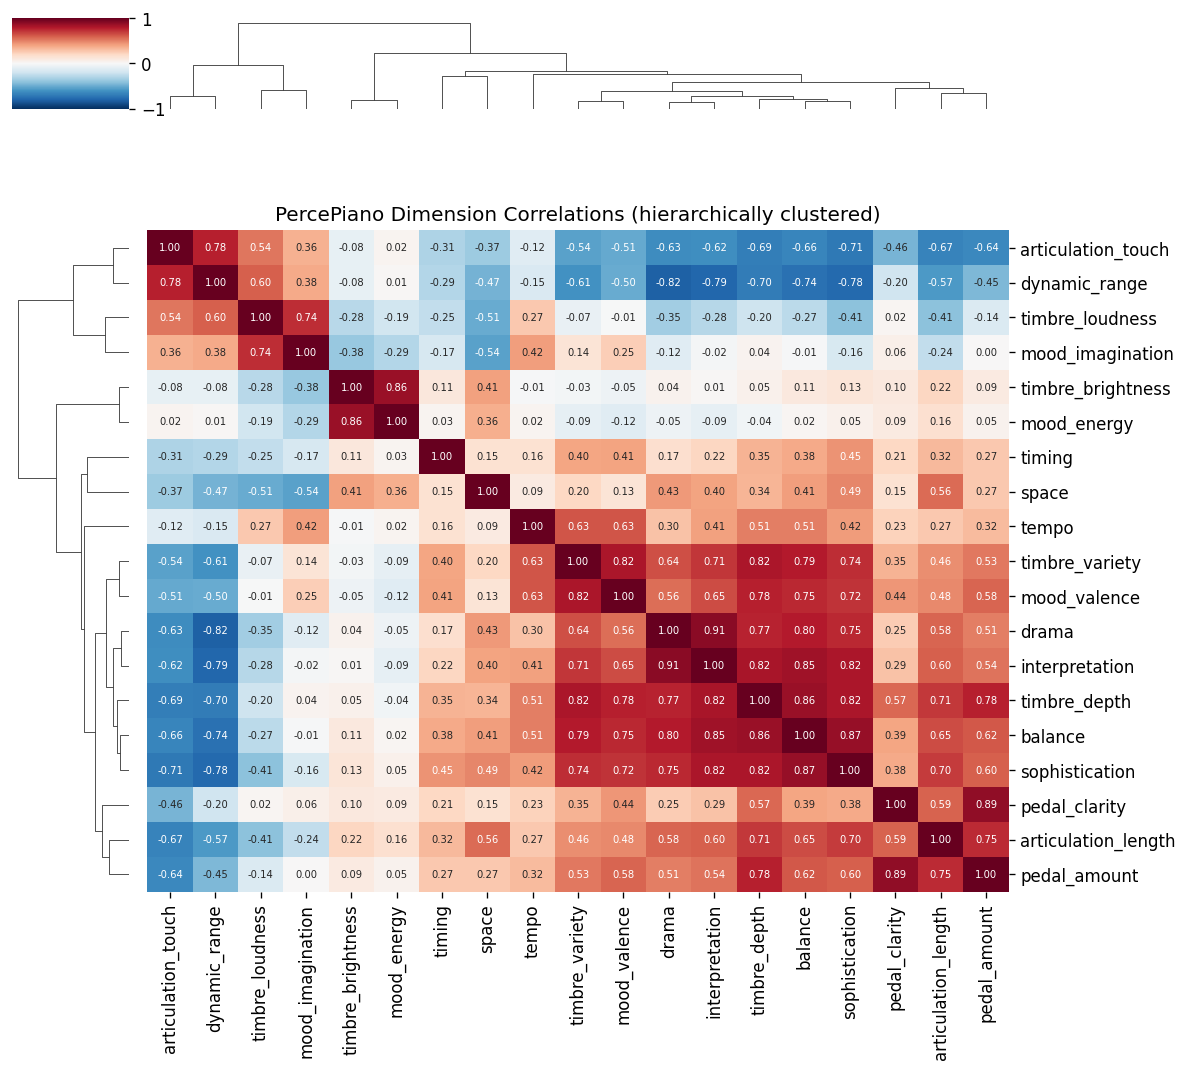

Cluster ordering: ['articulation_touch', 'dynamic_range', 'timbre_loudness', 'mood_imagination', 'timbre_brightness', 'mood_energy', 'timing', 'space', 'tempo', 'timbre_variety', 'mood_valence', 'drama', 'interpretation', 'timbre_depth', 'balance', 'sophistication', 'pedal_clarity', 'articulation_length', 'pedal_amount']


In [3]:
# Correlation heatmap with hierarchical clustering
corr = np.corrcoef(Y.T)  # [19, 19]

g = sns.clustermap(
    corr,
    xticklabels=DIM_NAMES,
    yticklabels=DIM_NAMES,
    cmap='RdBu_r',
    vmin=-1, vmax=1,
    figsize=(10, 9),
    annot=True, fmt='.2f', annot_kws={'size': 6},
    dendrogram_ratio=0.12,
)
g.ax_heatmap.set_title('PercePiano Dimension Correlations (hierarchically clustered)')
plt.tight_layout()
plt.show()

# Print cluster ordering
cluster_order = [DIM_NAMES[i] for i in g.dendrogram_row.reordered_ind]
print(f'Cluster ordering: {cluster_order}')

In [4]:
# Top correlated pairs
pairs = []
for i in range(N_DIMS):
    for j in range(i + 1, N_DIMS):
        pairs.append((DIM_NAMES[i], DIM_NAMES[j], corr[i, j]))
pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print('Top 15 correlated pairs:')
for d1, d2, r in pairs[:15]:
    print(f'  {d1:25s} <-> {d2:25s}  r = {r:+.3f}')

n_high = sum(1 for _, _, r in pairs if abs(r) > 0.7)
n_moderate = sum(1 for _, _, r in pairs if 0.5 < abs(r) <= 0.7)
print(f'\nPairs with |r| > 0.7: {n_high}/{len(pairs)}')
print(f'Pairs with 0.5 < |r| <= 0.7: {n_moderate}/{len(pairs)}')

Top 15 correlated pairs:
  drama                     <-> interpretation             r = +0.906
  pedal_amount              <-> pedal_clarity              r = +0.887
  balance                   <-> sophistication             r = +0.871
  timbre_depth              <-> balance                    r = +0.862
  timbre_brightness         <-> mood_energy                r = +0.860
  balance                   <-> interpretation             r = +0.847
  timbre_depth              <-> interpretation             r = +0.822
  dynamic_range             <-> drama                      r = -0.820
  timbre_variety            <-> mood_valence               r = +0.820
  sophistication            <-> interpretation             r = +0.818
  timbre_depth              <-> sophistication             r = +0.816
  timbre_variety            <-> timbre_depth               r = +0.815
  balance                   <-> drama                      r = +0.796
  timbre_variety            <-> balance                    r = +0

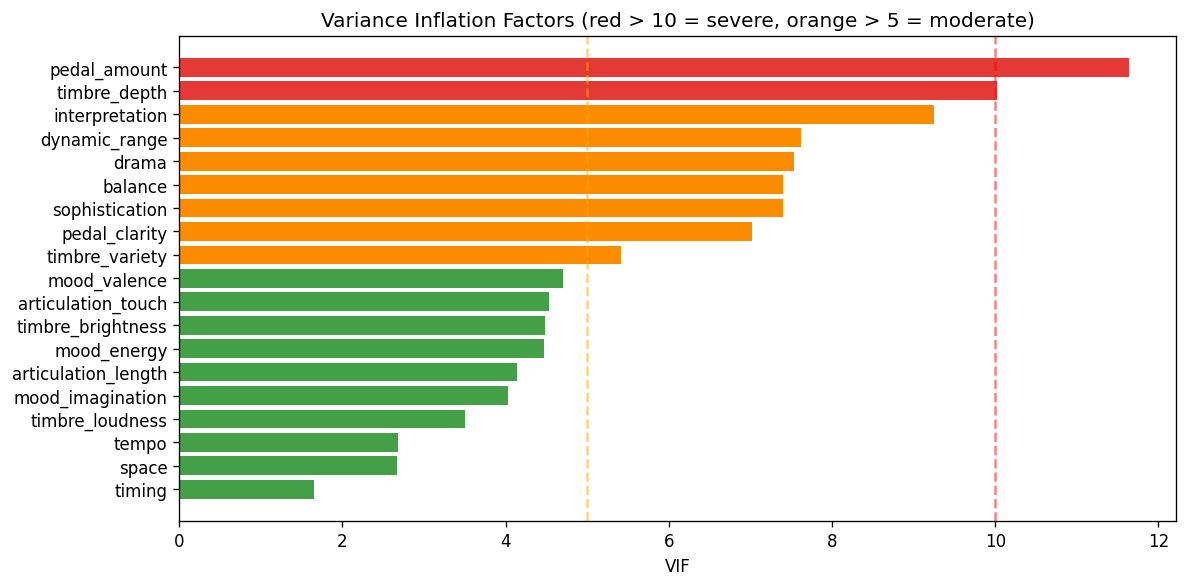

VIF per dimension:
  pedal_amount             :    11.63 *** SEVERE
  timbre_depth             :    10.02 *** SEVERE
  interpretation           :     9.26 ** moderate
  dynamic_range            :     7.62 ** moderate
  drama                    :     7.53 ** moderate
  balance                  :     7.40 ** moderate
  sophistication           :     7.40 ** moderate
  pedal_clarity            :     7.02 ** moderate
  timbre_variety           :     5.41 ** moderate
  mood_valence             :     4.70
  articulation_touch       :     4.53
  timbre_brightness        :     4.49
  mood_energy              :     4.47
  articulation_length      :     4.14
  mood_imagination         :     4.03
  timbre_loudness          :     3.50
  tempo                    :     2.68
  space                    :     2.66
  timing                   :     1.65


In [5]:
# Variance Inflation Factors
vifs = [variance_inflation_factor(Y_std, i) for i in range(N_DIMS)]

fig, ax = plt.subplots(figsize=(10, 5))
sorted_idx = np.argsort(vifs)[::-1]
colors = ['#e53935' if v > 10 else '#fb8c00' if v > 5 else '#43a047' for v in np.array(vifs)[sorted_idx]]
ax.barh(range(N_DIMS), np.array(vifs)[sorted_idx], color=colors)
ax.set_yticks(range(N_DIMS))
ax.set_yticklabels([DIM_NAMES[i] for i in sorted_idx])
ax.set_xlabel('VIF')
ax.set_title('Variance Inflation Factors (red > 10 = severe, orange > 5 = moderate)')
ax.axvline(10, color='red', linestyle='--', alpha=0.5)
ax.axvline(5, color='orange', linestyle='--', alpha=0.5)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print('VIF per dimension:')
for i in sorted_idx:
    flag = ' *** SEVERE' if vifs[i] > 10 else ' ** moderate' if vifs[i] > 5 else ''
    print(f'  {DIM_NAMES[i]:25s}: {vifs[i]:8.2f}{flag}')

## 3. Factor Analysis (PCA)

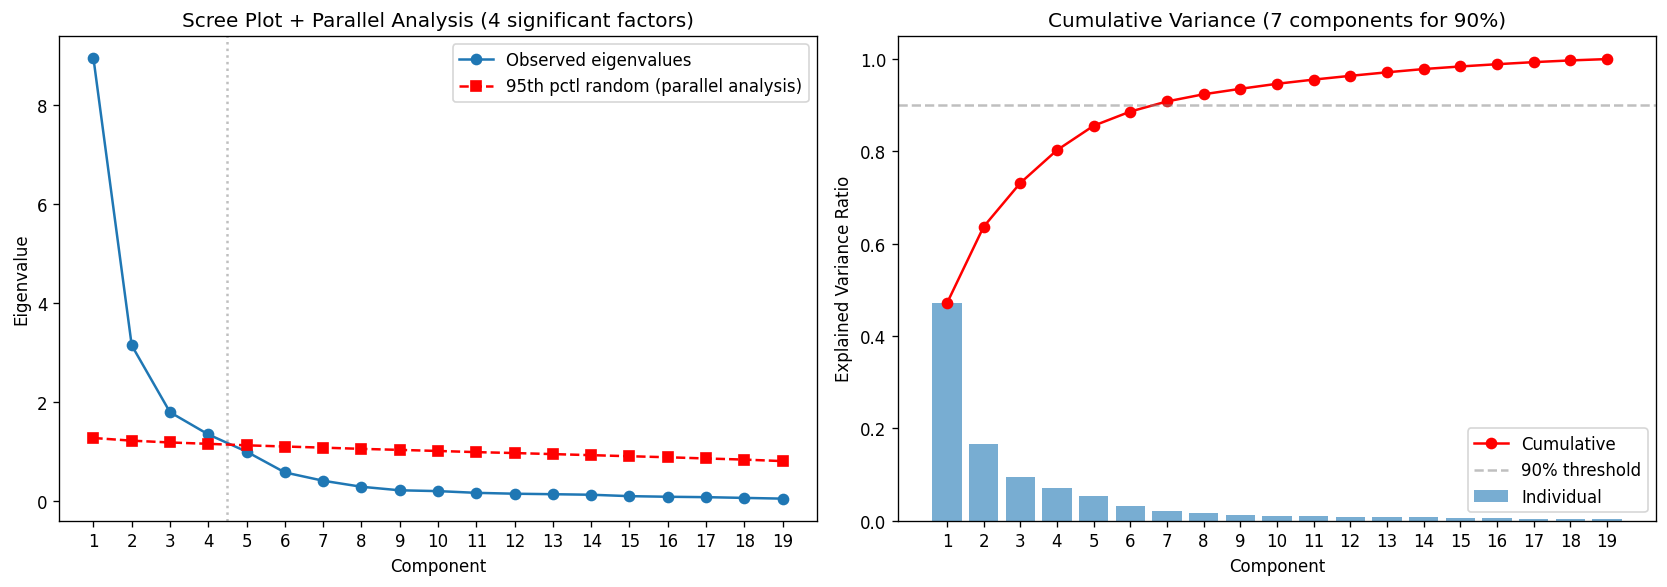

Parallel analysis: 4 statistically significant factors
Components for 90% variance: 7
Components for 95% variance: 11

Explained variance per component:
  PC1: 0.471 (cumulative: 0.471)
  PC2: 0.166 (cumulative: 0.637)
  PC3: 0.095 (cumulative: 0.732)
  PC4: 0.071 (cumulative: 0.803) <-- cutoff
  PC5: 0.053 (cumulative: 0.856)
  PC6: 0.031 (cumulative: 0.886)
  PC7: 0.022 (cumulative: 0.908)
  PC8: 0.016 (cumulative: 0.924)
  PC9: 0.012 (cumulative: 0.936)
  PC10: 0.011 (cumulative: 0.946)
  PC11: 0.009 (cumulative: 0.956)
  PC12: 0.008 (cumulative: 0.964)
  PC13: 0.008 (cumulative: 0.971)
  PC14: 0.007 (cumulative: 0.978)
  PC15: 0.006 (cumulative: 0.984)
  PC16: 0.005 (cumulative: 0.989)
  PC17: 0.004 (cumulative: 0.993)
  PC18: 0.004 (cumulative: 0.997)
  PC19: 0.003 (cumulative: 1.000)


In [6]:
# PCA on standardized labels
pca = PCA(n_components=N_DIMS)
pca.fit(Y_std)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

# Parallel analysis: Monte Carlo simulation for significant components
n_simulations = 1000
rng = np.random.default_rng(42)
random_eigenvalues = np.zeros((n_simulations, N_DIMS))
for i in range(n_simulations):
    random_data = rng.standard_normal((len(all_keys), N_DIMS))
    random_pca = PCA(n_components=N_DIMS)
    random_pca.fit(random_data)
    random_eigenvalues[i] = random_pca.explained_variance_

# 95th percentile of random eigenvalues
threshold_eigenvalues = np.percentile(random_eigenvalues, 95, axis=0)
n_significant = np.sum(pca.explained_variance_ > threshold_eigenvalues)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot with parallel analysis
components = np.arange(1, N_DIMS + 1)
axes[0].plot(components, pca.explained_variance_, 'o-', label='Observed eigenvalues')
axes[0].plot(components, threshold_eigenvalues, 's--', color='red', label='95th pctl random (parallel analysis)')
axes[0].axvline(n_significant + 0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Eigenvalue')
axes[0].set_title(f'Scree Plot + Parallel Analysis ({n_significant} significant factors)')
axes[0].legend()
axes[0].set_xticks(components)

# Cumulative variance
axes[1].bar(components, explained, alpha=0.6, label='Individual')
axes[1].plot(components, cumulative, 'o-', color='red', label='Cumulative')
axes[1].axhline(0.90, color='gray', linestyle='--', alpha=0.5, label='90% threshold')
n_90 = np.searchsorted(cumulative, 0.90) + 1
axes[1].set_xlabel('Component')
axes[1].set_ylabel('Explained Variance Ratio')
axes[1].set_title(f'Cumulative Variance ({n_90} components for 90%)')
axes[1].legend()
axes[1].set_xticks(components)

plt.tight_layout()
plt.show()

print(f'Parallel analysis: {n_significant} statistically significant factors')
print(f'Components for 90% variance: {n_90}')
print(f'Components for 95% variance: {np.searchsorted(cumulative, 0.95) + 1}')
print(f'\nExplained variance per component:')
for i, (e, c) in enumerate(zip(explained, cumulative)):
    marker = ' <-- cutoff' if i + 1 == n_significant else ''
    print(f'  PC{i+1}: {e:.3f} (cumulative: {c:.3f}){marker}')

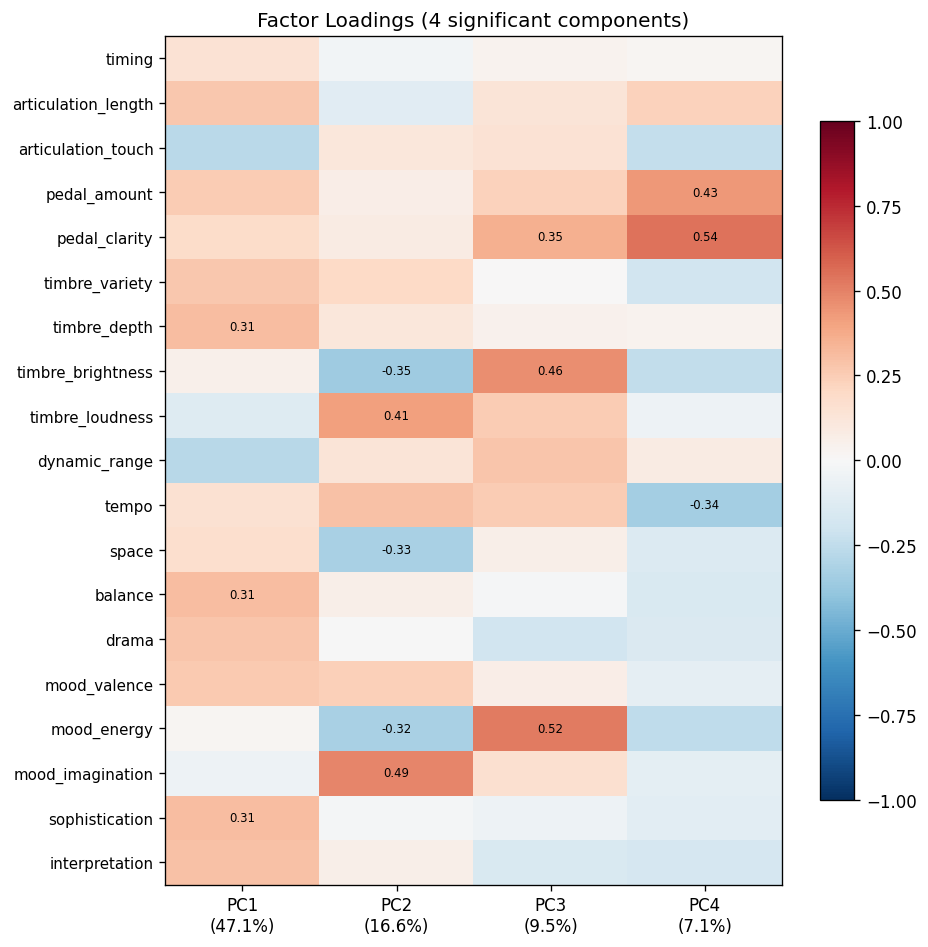

Factor interpretations (|loading| > 0.3):
  PC1 (47.1%): timbre_depth(+0.31), sophistication(+0.31), balance(+0.31)
  PC2 (16.6%): mood_imagination(+0.49), timbre_loudness(+0.41), timbre_brightness(-0.35), space(-0.33), mood_energy(-0.32)
  PC3 (9.5%): mood_energy(+0.52), timbre_brightness(+0.46), pedal_clarity(+0.35)
  PC4 (7.1%): pedal_clarity(+0.54), pedal_amount(+0.43), tempo(-0.34)


In [7]:
# Factor loadings heatmap (only significant components)
loadings = pca.components_[:n_significant].T  # [19, n_significant]

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(loadings, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax.set_yticks(range(N_DIMS))
ax.set_yticklabels(DIM_NAMES, fontsize=9)
ax.set_xticks(range(n_significant))
ax.set_xticklabels([f'PC{i+1}\n({explained[i]:.1%})' for i in range(n_significant)])
ax.set_title(f'Factor Loadings ({n_significant} significant components)')
fig.colorbar(im, ax=ax, shrink=0.8)

# Annotate loadings
for i in range(N_DIMS):
    for j in range(n_significant):
        val = loadings[i, j]
        if abs(val) > 0.3:
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=7,
                    color='white' if abs(val) > 0.6 else 'black')

plt.tight_layout()
plt.show()

# Interpret factors
print('Factor interpretations (|loading| > 0.3):')
for j in range(n_significant):
    strong = [(DIM_NAMES[i], loadings[i, j]) for i in range(N_DIMS) if abs(loadings[i, j]) > 0.3]
    strong.sort(key=lambda x: abs(x[1]), reverse=True)
    dims_str = ', '.join(f'{name}({v:+.2f})' for name, v in strong)
    print(f'  PC{j+1} ({explained[j]:.1%}): {dims_str}')

## 4. Per-Dimension Distributions

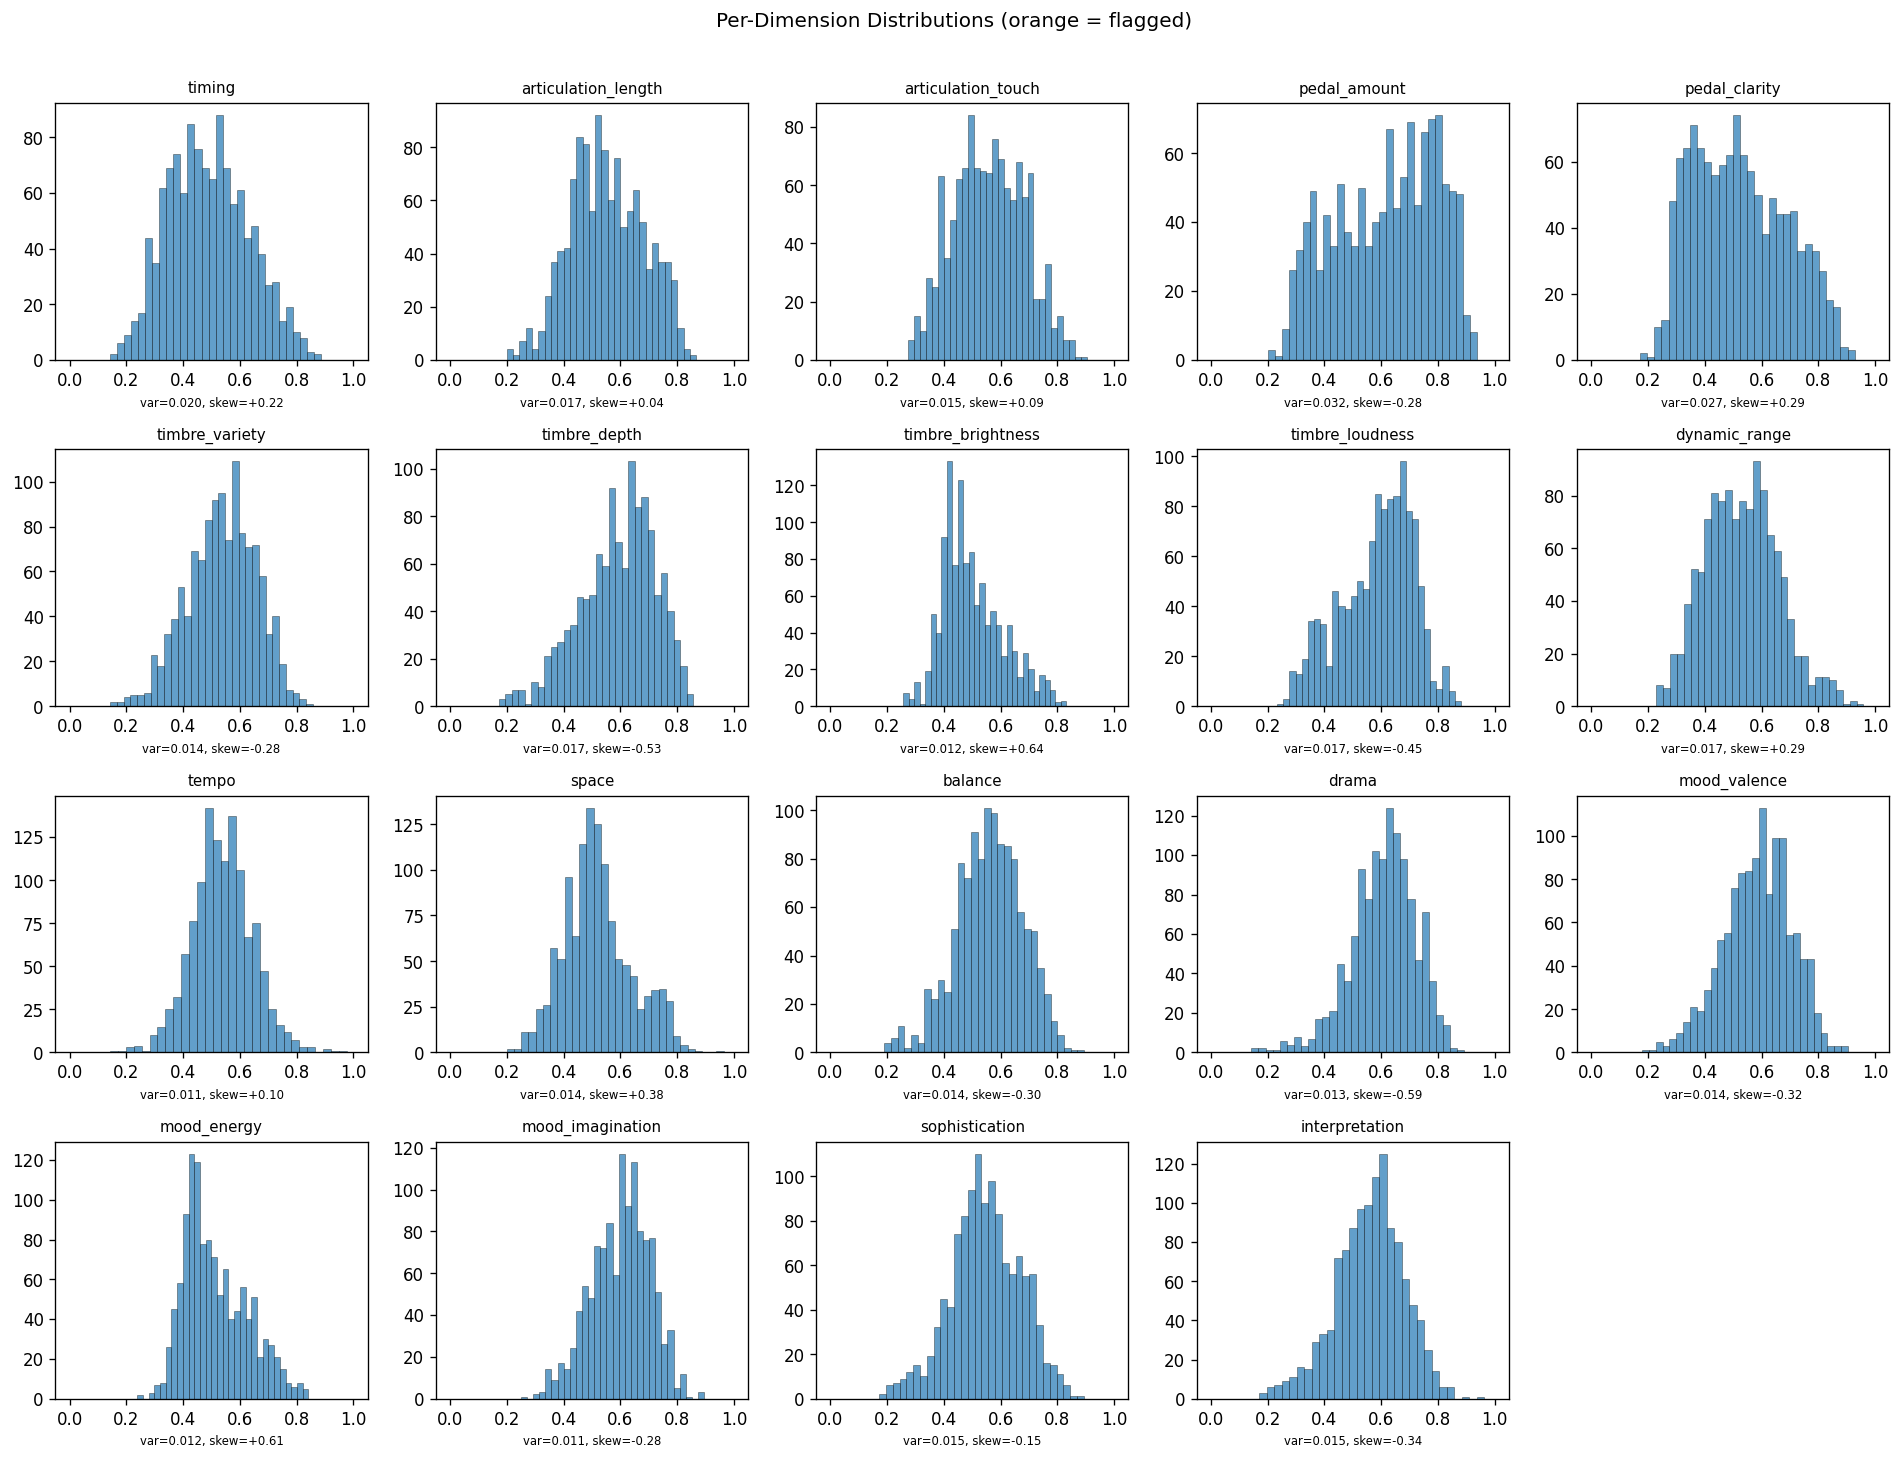

No dimensions flagged.


In [8]:
fig, axes = plt.subplots(4, 5, figsize=(16, 12))
axes = axes.flatten()

flagged = []
for i in range(N_DIMS):
    ax = axes[i]
    vals = Y[:, i]
    ax.hist(vals, bins=30, alpha=0.7, edgecolor='black', linewidth=0.3)
    ax.set_title(DIM_NAMES[i], fontsize=9)
    ax.set_xlim(-0.05, 1.05)

    var = np.var(vals)
    skew = sp_stats.skew(vals)
    floor_pct = np.mean(vals < 0.05)
    ceil_pct = np.mean(vals > 0.95)

    flags = []
    if var < 0.01:
        flags.append(f'low var ({var:.4f})')
    if abs(skew) > 1:
        flags.append(f'skew ({skew:+.2f})')
    if floor_pct > 0.5:
        flags.append(f'floor ({floor_pct:.0%})')
    if ceil_pct > 0.5:
        flags.append(f'ceil ({ceil_pct:.0%})')

    subtitle = f'var={var:.3f}, skew={skew:+.2f}'
    ax.set_xlabel(subtitle, fontsize=7)

    if flags:
        ax.patch.set_facecolor('#fff3e0')
        flagged.append((DIM_NAMES[i], flags))

# Hide last subplot if odd number of dims
for j in range(N_DIMS, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Per-Dimension Distributions (orange = flagged)', fontsize=12, y=1.01)
plt.tight_layout()
plt.show()

if flagged:
    print('Flagged dimensions:')
    for name, flags in flagged:
        print(f'  {name}: {" | ".join(flags)}')
else:
    print('No dimensions flagged.')

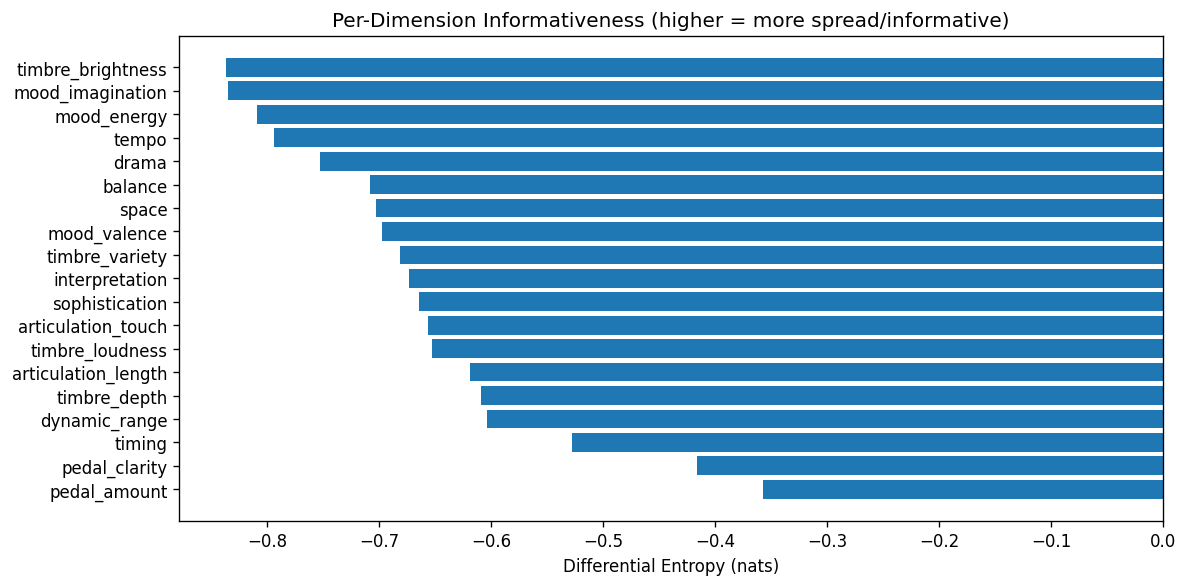

Entropy ranking (least to most informative):
  timbre_brightness        : -0.837 nats
  mood_imagination         : -0.835 nats
  mood_energy              : -0.809 nats
  tempo                    : -0.794 nats
  drama                    : -0.752 nats
  balance                  : -0.708 nats
  space                    : -0.702 nats
  mood_valence             : -0.697 nats
  timbre_variety           : -0.681 nats
  interpretation           : -0.673 nats
  sophistication           : -0.664 nats
  articulation_touch       : -0.656 nats
  timbre_loudness          : -0.653 nats
  articulation_length      : -0.619 nats
  timbre_depth             : -0.609 nats
  dynamic_range            : -0.603 nats
  timing                   : -0.528 nats
  pedal_clarity            : -0.416 nats
  pedal_amount             : -0.357 nats


In [9]:
# Differential entropy per dimension (informativeness score)
entropies = []
for i in range(N_DIMS):
    vals = Y[:, i]
    # Use KDE-based entropy estimate
    kde = sp_stats.gaussian_kde(vals)
    # Sample points for entropy estimation
    x_grid = np.linspace(vals.min() - 0.1, vals.max() + 0.1, 500)
    pdf = kde(x_grid)
    # Numerical integration of -p*log(p)
    pdf = pdf[pdf > 0]
    dx = x_grid[1] - x_grid[0]
    entropy = -np.sum(pdf * np.log(pdf) * dx)
    entropies.append(entropy)

fig, ax = plt.subplots(figsize=(10, 5))
sorted_idx = np.argsort(entropies)
ax.barh(range(N_DIMS), np.array(entropies)[sorted_idx])
ax.set_yticks(range(N_DIMS))
ax.set_yticklabels([DIM_NAMES[i] for i in sorted_idx])
ax.set_xlabel('Differential Entropy (nats)')
ax.set_title('Per-Dimension Informativeness (higher = more spread/informative)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print('Entropy ranking (least to most informative):')
for i in sorted_idx:
    print(f'  {DIM_NAMES[i]:25s}: {entropies[i]:.3f} nats')

## -- Load MuQ Embeddings (required for sections 5-9) --

Run `scripts/extract_percepiano_muq.py` first if `muq_embeddings.pt` does not exist.

In [10]:
# Load pre-extracted MuQ embeddings
emb_path = CACHE_DIR / 'muq_embeddings.pt'
embeddings = torch.load(emb_path, map_location='cpu', weights_only=True)

# Align keys: only keep segments that have both labels and embeddings
keys = sorted(set(all_keys) & set(embeddings.keys()))
Y = np.array([raw_labels[k][:19] for k in keys])  # overwrite with aligned subset
Y_std = StandardScaler().fit_transform(Y)

# Stats-pool MuQ embeddings: mean + std -> [2048]
X_muq = np.stack([
    torch.cat([embeddings[k].mean(dim=0), embeddings[k].std(dim=0)]).numpy()
    for k in keys
])

print(f'Aligned samples (labels + embeddings): {len(keys)}')
print(f'Labels shape: {Y.shape}')
print(f'MuQ features shape: {X_muq.shape}')

Aligned samples (labels + embeddings): 1201
Labels shape: (1201, 19)
MuQ features shape: (1201, 2048)


## 5. MuQ Probing (per-dimension audibility)

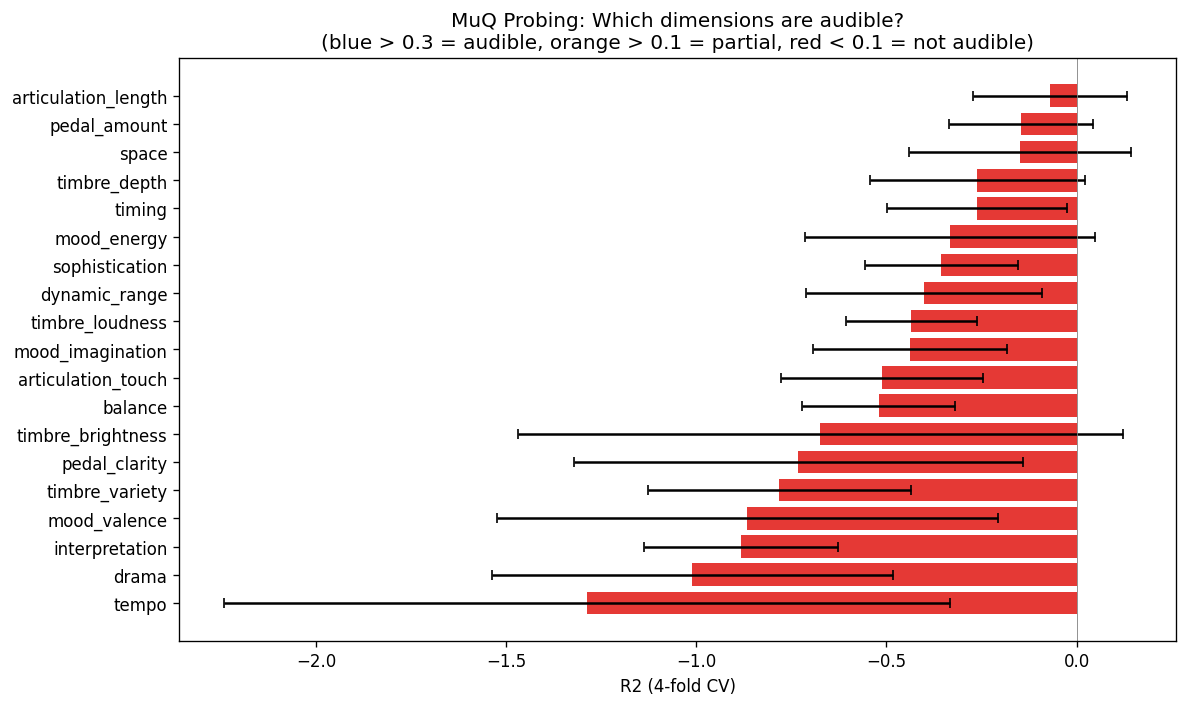

Per-dimension R2 (MuQ -> PercePiano score):
  articulation_length      : R2=-0.070 [NOT AUDIBLE]  folds: [-0.432 -0.095 0.139 -0.137]
  pedal_amount             : R2=-0.145 [NOT AUDIBLE]  folds: [-0.054 -0.167 0.017 -0.478]
  space                    : R2=-0.150 [NOT AUDIBLE]  folds: [-0.135 0.132 -0.125 -0.670]
  timbre_depth             : R2=-0.261 [NOT AUDIBLE]  folds: [-0.417 0.039 -0.010 -0.640]
  timing                   : R2=-0.262 [NOT AUDIBLE]  folds: [-0.268 0.134 -0.356 -0.503]
  mood_energy              : R2=-0.334 [NOT AUDIBLE]  folds: [-1.063 -0.014 -0.501 -0.734]
  sophistication           : R2=-0.355 [NOT AUDIBLE]  folds: [-0.416 -0.023 -0.505 -0.520]
  dynamic_range            : R2=-0.402 [NOT AUDIBLE]  folds: [-0.962 -0.188 -0.464 -0.211]
  timbre_loudness          : R2=-0.434 [NOT AUDIBLE]  folds: [-0.340 -0.598 -0.748 -0.354]
  mood_imagination         : R2=-0.437 [NOT AUDIBLE]  folds: [-0.345 -0.042 -0.574 -0.716]
  articulation_touch       : R2=-0.512 [NOT AUDIBLE

In [11]:
# For each dimension, train Ridge regression: MuQ -> score, 4-fold CV
key_to_idx = {k: i for i, k in enumerate(keys)}

r2_per_dim = np.zeros(N_DIMS)
r2_per_dim_per_fold = np.zeros((N_DIMS, len(folds)))

for dim_i in range(N_DIMS):
    y_dim = Y[:, dim_i]
    all_true, all_pred = [], []

    for fold_i, fold in enumerate(folds):
        train_idx = [key_to_idx[k] for k in fold['train'] if k in key_to_idx]
        val_idx = [key_to_idx[k] for k in fold['val'] if k in key_to_idx]

        scaler = StandardScaler()
        X_tr = scaler.fit_transform(X_muq[train_idx])
        X_va = scaler.transform(X_muq[val_idx])

        ridge = Ridge(alpha=1.0)
        ridge.fit(X_tr, y_dim[train_idx])
        preds = ridge.predict(X_va)

        r2_fold = r2_score(y_dim[val_idx], preds)
        r2_per_dim_per_fold[dim_i, fold_i] = r2_fold

        all_true.extend(y_dim[val_idx])
        all_pred.extend(preds)

    r2_per_dim[dim_i] = r2_score(all_true, all_pred)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
sorted_idx = np.argsort(r2_per_dim)[::-1]
colors = ['#2196F3' if r > 0.3 else '#FF9800' if r > 0.1 else '#e53935' for r in r2_per_dim[sorted_idx]]
ax.barh(range(N_DIMS), r2_per_dim[sorted_idx], color=colors, xerr=r2_per_dim_per_fold[sorted_idx].std(axis=1), capsize=3)
ax.set_yticks(range(N_DIMS))
ax.set_yticklabels([DIM_NAMES[i] for i in sorted_idx])
ax.set_xlabel('R2 (4-fold CV)')
ax.set_title('MuQ Probing: Which dimensions are audible?\n(blue > 0.3 = audible, orange > 0.1 = partial, red < 0.1 = not audible)')
ax.axvline(0, color='gray', linewidth=0.5)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print('Per-dimension R2 (MuQ -> PercePiano score):')
for i in sorted_idx:
    fold_str = ' '.join(f'{r2_per_dim_per_fold[i, f]:.3f}' for f in range(len(folds)))
    label = 'AUDIBLE' if r2_per_dim[i] > 0.3 else 'partial' if r2_per_dim[i] > 0.1 else 'NOT AUDIBLE'
    print(f'  {DIM_NAMES[i]:25s}: R2={r2_per_dim[i]:.3f} [{label}]  folds: [{fold_str}]')

## 6. MuQ Residual Analysis

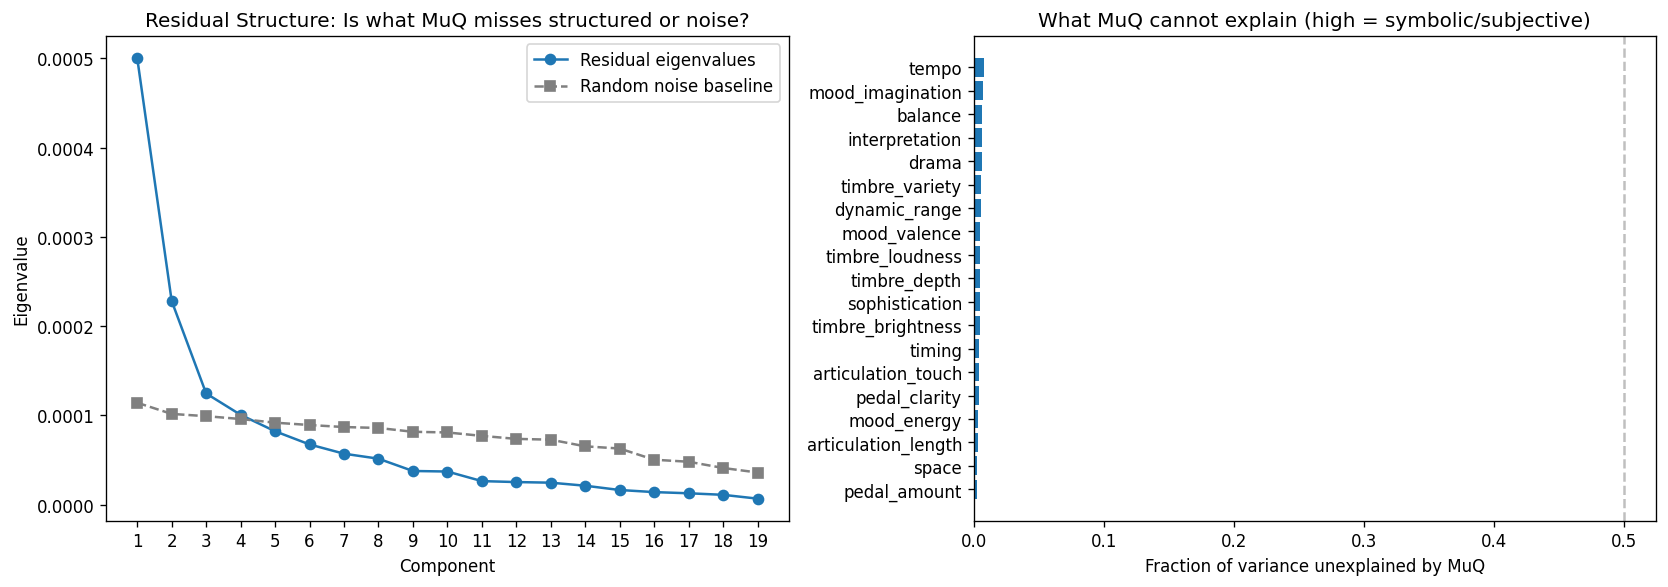

Structured residual components (above noise floor): 4

Per-dimension unexplained variance:
  tempo                    : 0.008 unexplained
  mood_imagination         : 0.007 unexplained
  balance                  : 0.006 unexplained
  interpretation           : 0.006 unexplained
  drama                    : 0.006 unexplained
  timbre_variety           : 0.006 unexplained
  dynamic_range            : 0.005 unexplained
  mood_valence             : 0.005 unexplained
  timbre_loudness          : 0.005 unexplained
  timbre_depth             : 0.005 unexplained
  sophistication           : 0.005 unexplained
  timbre_brightness        : 0.005 unexplained
  timing                   : 0.004 unexplained
  articulation_touch       : 0.004 unexplained
  pedal_clarity            : 0.004 unexplained
  mood_energy              : 0.004 unexplained
  articulation_length      : 0.003 unexplained
  space                    : 0.003 unexplained
  pedal_amount             : 0.003 unexplained


In [12]:
# Fit linear map: MuQ -> all 19 dims simultaneously
scaler_full = StandardScaler()
X_muq_std = scaler_full.fit_transform(X_muq)

ridge_multi = Ridge(alpha=1.0)
ridge_multi.fit(X_muq_std, Y)
Y_pred = ridge_multi.predict(X_muq_std)

# Residuals: what PercePiano labels capture that MuQ can't explain
residuals = Y - Y_pred  # [N, 19]

# PCA on residuals to check if structured
pca_resid = PCA(n_components=N_DIMS)
pca_resid.fit(residuals)
resid_explained = pca_resid.explained_variance_ratio_
resid_cumulative = np.cumsum(resid_explained)

# Compare to random noise baseline
random_residuals = rng.standard_normal(residuals.shape) * residuals.std(axis=0)
pca_random = PCA(n_components=N_DIMS)
pca_random.fit(random_residuals)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree comparison
components = np.arange(1, N_DIMS + 1)
axes[0].plot(components, pca_resid.explained_variance_, 'o-', label='Residual eigenvalues')
axes[0].plot(components, pca_random.explained_variance_, 's--', color='gray', label='Random noise baseline')
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Eigenvalue')
axes[0].set_title('Residual Structure: Is what MuQ misses structured or noise?')
axes[0].legend()
axes[0].set_xticks(components)

# Per-dimension residual variance
resid_var = residuals.var(axis=0)
total_var = Y.var(axis=0)
unexplained_frac = resid_var / total_var  # 1 - R2 per dim

sorted_idx = np.argsort(unexplained_frac)[::-1]
axes[1].barh(range(N_DIMS), unexplained_frac[sorted_idx])
axes[1].set_yticks(range(N_DIMS))
axes[1].set_yticklabels([DIM_NAMES[i] for i in sorted_idx])
axes[1].set_xlabel('Fraction of variance unexplained by MuQ')
axes[1].set_title('What MuQ cannot explain (high = symbolic/subjective)')
axes[1].axvline(0.5, color='gray', linestyle='--', alpha=0.5)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Residual correlation structure
resid_corr = np.corrcoef(residuals.T)
n_structured = np.sum(pca_resid.explained_variance_ > pca_random.explained_variance_)
print(f'Structured residual components (above noise floor): {n_structured}')
print(f'\nPer-dimension unexplained variance:')
for i in sorted_idx:
    print(f'  {DIM_NAMES[i]:25s}: {unexplained_frac[i]:.3f} unexplained')

## 7. UMAP Visualization

/Users/jdhiman/Documents/crescendai/model/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jdhiman/Documents/crescendai/model/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


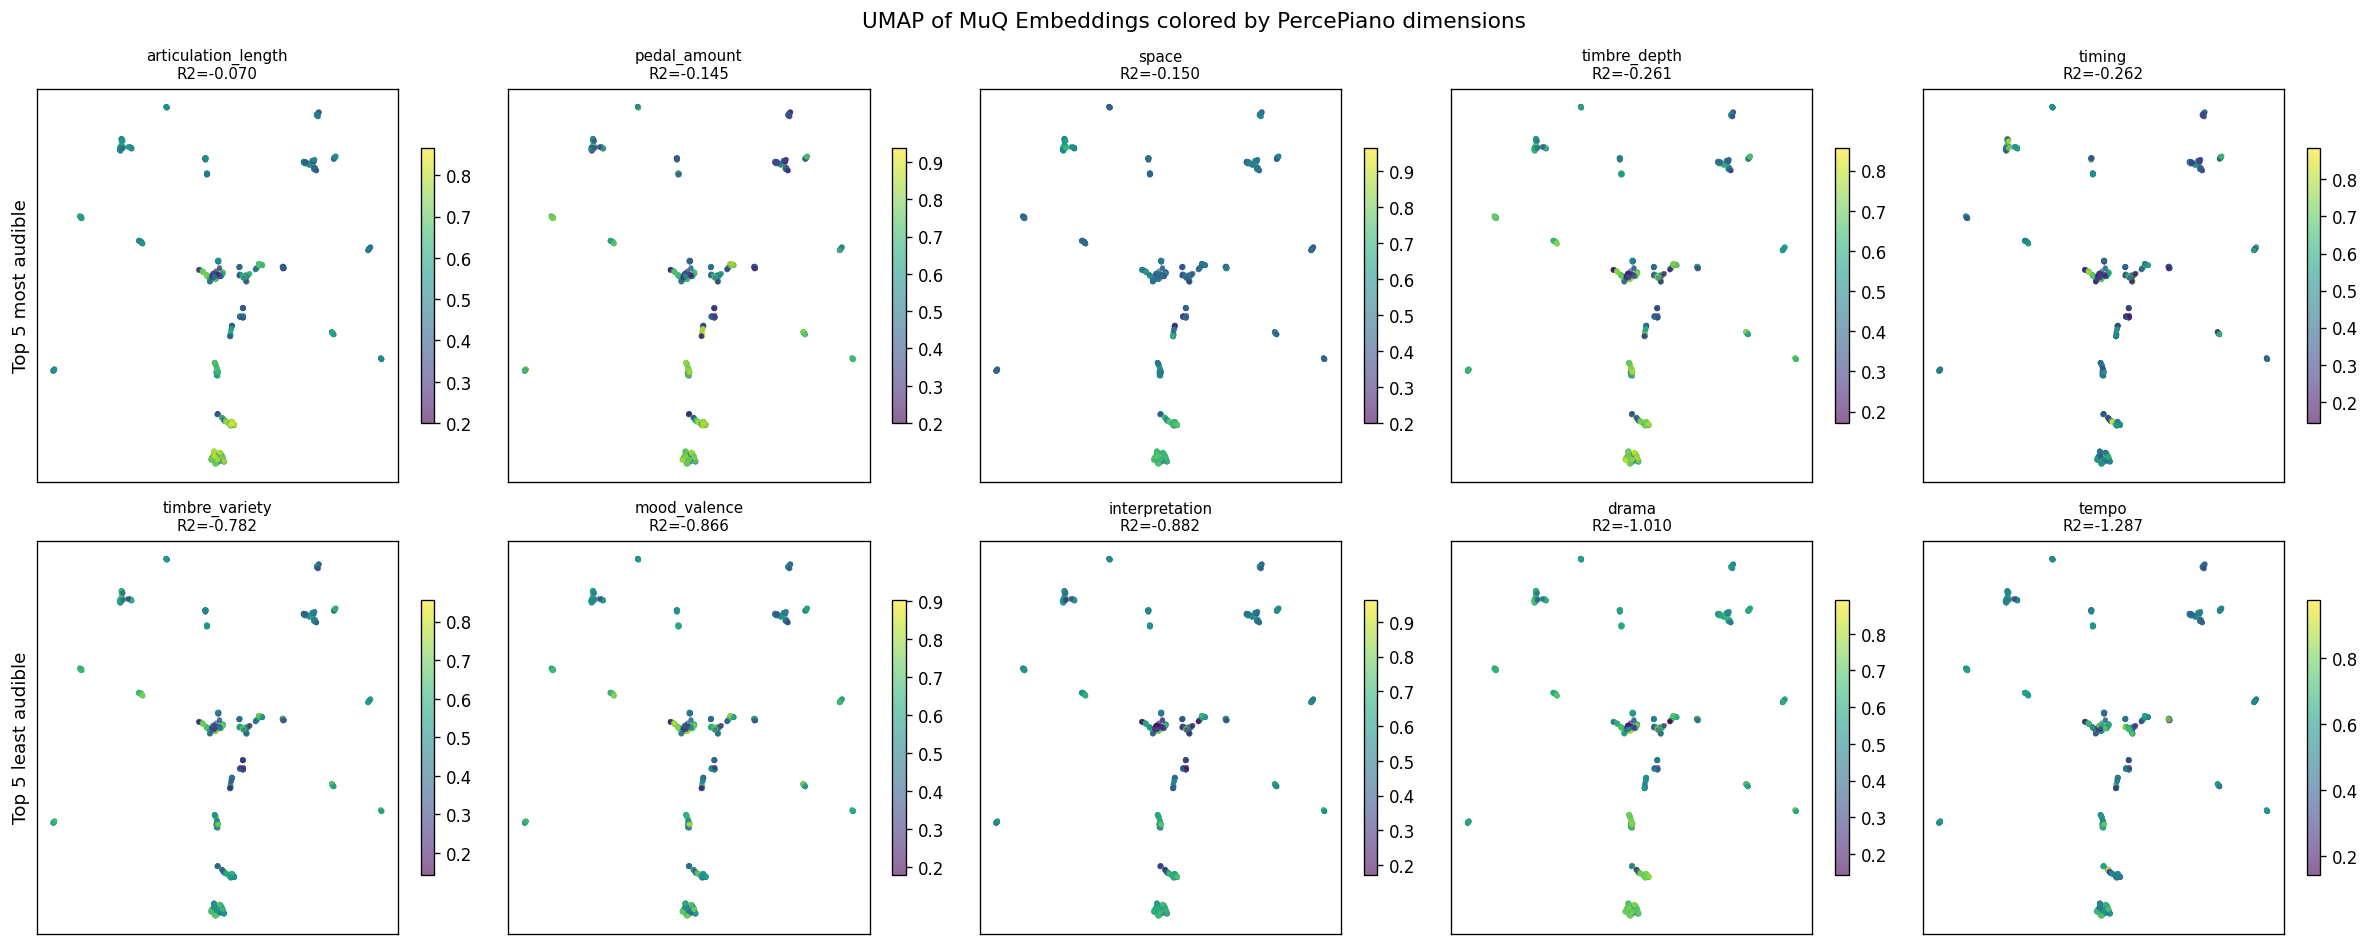

In [13]:
# UMAP on stats-pooled MuQ embeddings
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(X_muq_std)

# Select top-5 most audible and top-5 least audible dimensions
audibility_rank = np.argsort(r2_per_dim)[::-1]
top_audible = audibility_rank[:5]
least_audible = audibility_rank[-5:]
dims_to_show = np.concatenate([top_audible, least_audible])

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for plot_i, dim_i in enumerate(dims_to_show):
    row = plot_i // 5
    col = plot_i % 5
    ax = axes[row, col]

    scatter = ax.scatter(
        embedding_2d[:, 0], embedding_2d[:, 1],
        c=Y[:, dim_i], cmap='viridis', s=5, alpha=0.6,
    )
    ax.set_title(f'{DIM_NAMES[dim_i]}\nR2={r2_per_dim[dim_i]:.3f}', fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.colorbar(scatter, ax=ax, shrink=0.7)

axes[0, 0].set_ylabel('Top 5 most audible', fontsize=11)
axes[1, 0].set_ylabel('Top 5 least audible', fontsize=11)
fig.suptitle('UMAP of MuQ Embeddings colored by PercePiano dimensions', fontsize=13)
plt.tight_layout()
plt.show()

## 8. Canonical Correlation Analysis (CCA)

MuQ PCA: 78.5% variance retained in 50 components


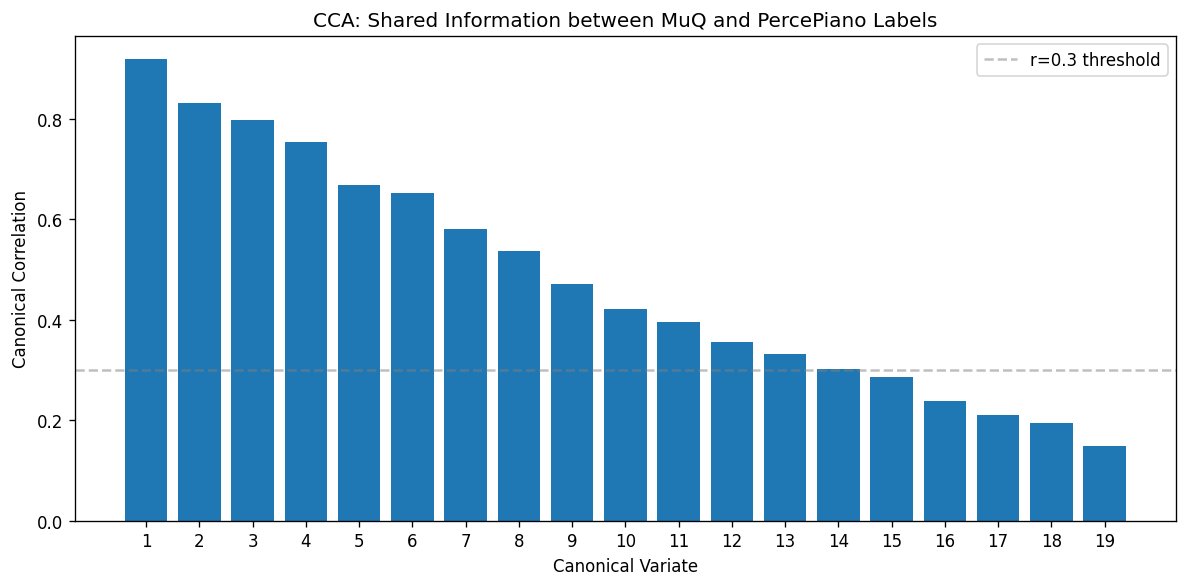

Canonical correlations: ['0.919', '0.832', '0.797', '0.753', '0.669', '0.653', '0.580', '0.537', '0.471', '0.422', '0.395', '0.356', '0.331', '0.302', '0.286', '0.238', '0.211', '0.194', '0.148']
Significant canonical variates (r > 0.3): 14/19
Total shared variance (sum r^2): 5.363


In [14]:
# CCA between MuQ embeddings and PercePiano labels
# Reduce MuQ dimensionality first via PCA (CCA needs n_samples > n_features)
n_cca_components = min(N_DIMS, 19)  # Match label dimensionality
pca_muq = PCA(n_components=50)  # Reduce 2048 -> 50
X_muq_pca = pca_muq.fit_transform(X_muq_std)
print(f'MuQ PCA: {pca_muq.explained_variance_ratio_.sum():.1%} variance retained in 50 components')

cca = CCA(n_components=n_cca_components)
X_c, Y_c = cca.fit_transform(X_muq_pca, Y)

# Canonical correlations
canonical_corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_cca_components)]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(1, n_cca_components + 1), canonical_corrs)
ax.set_xlabel('Canonical Variate')
ax.set_ylabel('Canonical Correlation')
ax.set_title('CCA: Shared Information between MuQ and PercePiano Labels')
ax.set_xticks(range(1, n_cca_components + 1))
ax.axhline(0.3, color='gray', linestyle='--', alpha=0.5, label='r=0.3 threshold')
ax.legend()
plt.tight_layout()
plt.show()

n_significant_cca = sum(1 for c in canonical_corrs if c > 0.3)
print(f'Canonical correlations: {[f"{c:.3f}" for c in canonical_corrs]}')
print(f'Significant canonical variates (r > 0.3): {n_significant_cca}/{n_cca_components}')
print(f'Total shared variance (sum r^2): {sum(c**2 for c in canonical_corrs):.3f}')

## 9. Downstream: STOP Prediction with Reduced Dims

Reuse the masterclass 98-segment STOP/CONTINUE data to test whether reduced dimension sets improve or hurt prediction.

In [15]:
from masterclass_experiments.data import load_moments, identify_segments
from masterclass_experiments.features import stats_pool
from masterclass_experiments.evaluation import leave_one_video_out_cv

REPO_ROOT = MODEL_ROOT.parent
MOMENTS_PATH = REPO_ROOT / 'tools' / 'masterclass-pipeline' / 'all_moments.jsonl'
SEGMENT_DIR = MASTERCLASS_CACHE / 'segments'
MUQ_CACHE_DIR = MASTERCLASS_CACHE / 'muq_embeddings'
CHECKPOINT_DIR = MODEL_ROOT / 'data' / 'checkpoints' / 'percepiano'
CHECKPOINT_PATHS = sorted(CHECKPOINT_DIR.glob('fold*_best.ckpt'))

# Load masterclass data
moments = load_moments(MOMENTS_PATH)
segments = identify_segments(moments)
segment_ids = np.array([s.segment_id for s in segments])
video_ids = np.array([s.video_id for s in segments])
stop_labels = np.array([1 if s.label == 'stop' else 0 for s in segments])

print(f'Masterclass segments: {len(segments)} ({stop_labels.sum()} STOP, {(1-stop_labels).sum()} CONTINUE)')
print(f'PercePiano checkpoints: {len(CHECKPOINT_PATHS)}')

Masterclass segments: 98 (61 STOP, 37 CONTINUE)
PercePiano checkpoints: 3


In [16]:
# Extract MuQ embeddings for masterclass segments (cached)
from audio_experiments.extractors.muq import MuQExtractor
from masterclass_experiments.features import extract_quality_scores

extractor = MuQExtractor(cache_dir=MUQ_CACHE_DIR)
mc_raw_embeddings = {}
for seg in segments:
    wav_path = SEGMENT_DIR / f'{seg.segment_id}.wav'
    mc_raw_embeddings[seg.segment_id] = extractor.extract_from_file(wav_path)

# Get 19-dim quality scores
mc_quality = extract_quality_scores(mc_raw_embeddings, CHECKPOINT_PATHS)
X_mc_quality = np.stack([mc_quality[sid].numpy() for sid in segment_ids])  # [98, 19]
print(f'Quality scores shape: {X_mc_quality.shape}')

Loading MuQ-large-msd-iter (last hidden state) on mps...


/Users/jdhiman/Documents/crescendai/model/.venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Model loaded. Hidden size: 1024


/Users/jdhiman/Documents/crescendai/model/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.6.0, which is newer than your current Lightning version: v2.5.5


Quality scores shape: (98, 19)


In [17]:
# Compare STOP prediction with different dimension reduction strategies
results = {}

# 1. All 19 dims (baseline)
r = leave_one_video_out_cv(X_mc_quality, stop_labels, video_ids, segment_ids)
results['All 19 dims'] = r['auc']

# 2. PCA-reduced (use n_significant from parallel analysis)
pca_mc = PCA(n_components=n_significant)
X_mc_pca = pca_mc.fit_transform(StandardScaler().fit_transform(X_mc_quality))
r = leave_one_video_out_cv(X_mc_pca, stop_labels, video_ids, segment_ids)
results[f'PCA ({n_significant} components)'] = r['auc']

# 3. Top audible dims only (R2 > 0.1 from probing)
audible_mask = r2_per_dim > 0.1
audible_dims = [DIM_NAMES[i] for i in range(N_DIMS) if audible_mask[i]]
X_mc_audible = X_mc_quality[:, audible_mask]
r = leave_one_video_out_cv(X_mc_audible, stop_labels, video_ids, segment_ids)
results[f'Audible only ({sum(audible_mask)} dims)'] = r['auc']

# 4. Non-audible dims only (R2 < 0.1) -- the "symbolic" ones
non_audible_mask = ~audible_mask
if non_audible_mask.sum() > 0:
    non_audible_dims = [DIM_NAMES[i] for i in range(N_DIMS) if non_audible_mask[i]]
    X_mc_non_audible = X_mc_quality[:, non_audible_mask]
    r = leave_one_video_out_cv(X_mc_non_audible, stop_labels, video_ids, segment_ids)
    results[f'Non-audible only ({sum(non_audible_mask)} dims)'] = r['auc']

# 5. Category-level means (collapse correlated groups)
category_features = []
category_names = []
for cat_name, cat_dims in DIMENSION_CATEGORIES.items():
    cat_idx = [DIM_NAMES.index(d) for d in cat_dims]
    category_features.append(X_mc_quality[:, cat_idx].mean(axis=1))
    category_names.append(cat_name)
X_mc_cats = np.column_stack(category_features)
r = leave_one_video_out_cv(X_mc_cats, stop_labels, video_ids, segment_ids)
results[f'Category means ({len(category_names)} cats)'] = r['auc']

# 6. Top-5 by probing R2
top5_idx = np.argsort(r2_per_dim)[::-1][:5]
top5_dims = [DIM_NAMES[i] for i in top5_idx]
X_mc_top5 = X_mc_quality[:, top5_idx]
r = leave_one_video_out_cv(X_mc_top5, stop_labels, video_ids, segment_ids)
results[f'Top-5 audible ({top5_dims})'] = r['auc']

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 5))
names = list(results.keys())
aucs = list(results.values())
sorted_pairs = sorted(zip(aucs, names), reverse=True)
aucs_sorted = [a for a, _ in sorted_pairs]
names_sorted = [n for _, n in sorted_pairs]

colors = ['#2196F3' if a >= max(aucs) - 0.01 else '#90CAF9' for a in aucs_sorted]
ax.barh(range(len(names_sorted)), aucs_sorted, color=colors)
ax.set_yticks(range(len(names_sorted)))
ax.set_yticklabels(names_sorted)
ax.set_xlabel('LOVO AUC')
ax.set_title('STOP Prediction: Which dimension subsets work best?')
ax.set_xlim(0.4, 1.0)
for i, v in enumerate(aucs_sorted):
    ax.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print('STOP prediction AUC by dimension subset:')
for name, auc in sorted_pairs:
    delta = auc - results['All 19 dims']
    print(f'  {name:40s}: AUC={auc:.3f} (delta={delta:+.3f})')

ValueError: Found array with 0 feature(s) (shape=(73, 0)) while a minimum of 1 is required by StandardScaler.

## 10. Competition Validation (T2 -- deferred)

Placeholder for Spearman correlation between PercePiano dimensions and competition ordinal placement. Requires T2 data to be synced.

In [ ]:
# TODO: Load T2 competition data and compute per-dimension Spearman correlation
# with ordinal placement (1st > 2nd > semifinal > eliminated).
#
# Expected analysis:
# - For each PercePiano dimension, compute Spearman rho with placement rank
# - Dimensions that correlate with competition outcomes provide external validity
# - Dimensions with no correlation may be noisy or subjective
print('T2 competition data not yet available. Sync from GDrive to proceed.')

## 11. Summary

In [18]:
print('=' * 70)
print('PERCEPIANO DATA QUALITY AUDIT -- SUMMARY')
print('=' * 70)

print(f'\n1. REDUNDANCY')
print(f'   Pairs with |r| > 0.7: {n_high}/{len(pairs)}')
severe_vif = sum(1 for v in vifs if v > 10)
print(f'   Dimensions with VIF > 10: {severe_vif}/{N_DIMS}')

print(f'\n2. FACTOR STRUCTURE')
print(f'   Parallel analysis: {n_significant} significant factors')
print(f'   Components for 90% variance: {n_90}')

print(f'\n3. DISTRIBUTION FLAGS')
if flagged:
    for name, flags in flagged:
        print(f'   {name}: {", ".join(flags)}')
else:
    print('   None flagged')

print(f'\n4. AUDIBILITY (MuQ probing R2)')
for i in np.argsort(r2_per_dim)[::-1]:
    label = 'AUDIBLE' if r2_per_dim[i] > 0.3 else 'partial' if r2_per_dim[i] > 0.1 else 'NOT AUDIBLE'
    print(f'   {DIM_NAMES[i]:25s}: R2={r2_per_dim[i]:.3f} [{label}]')

print(f'\n5. RESIDUAL STRUCTURE')
print(f'   Structured residual components: {n_structured}')

print(f'\n6. CCA')
print(f'   Significant canonical variates: {n_significant_cca}')
print(f'   Total shared variance: {sum(c**2 for c in canonical_corrs):.3f}')

print(f'\n7. STOP PREDICTION')
for auc_val, name in sorted_pairs:
    print(f'   {name:40s}: AUC={auc_val:.3f}')

print('\n' + '=' * 70)

PERCEPIANO DATA QUALITY AUDIT -- SUMMARY

1. REDUNDANCY
   Pairs with |r| > 0.7: 31/171
   Dimensions with VIF > 10: 2/19

2. FACTOR STRUCTURE
   Parallel analysis: 4 significant factors
   Components for 90% variance: 7

3. DISTRIBUTION FLAGS
   None flagged

4. AUDIBILITY (MuQ probing R2)
   articulation_length      : R2=-0.070 [NOT AUDIBLE]
   pedal_amount             : R2=-0.145 [NOT AUDIBLE]
   space                    : R2=-0.150 [NOT AUDIBLE]
   timbre_depth             : R2=-0.261 [NOT AUDIBLE]
   timing                   : R2=-0.262 [NOT AUDIBLE]
   mood_energy              : R2=-0.334 [NOT AUDIBLE]
   sophistication           : R2=-0.355 [NOT AUDIBLE]
   dynamic_range            : R2=-0.402 [NOT AUDIBLE]
   timbre_loudness          : R2=-0.434 [NOT AUDIBLE]
   mood_imagination         : R2=-0.437 [NOT AUDIBLE]
   articulation_touch       : R2=-0.512 [NOT AUDIBLE]
   balance                  : R2=-0.520 [NOT AUDIBLE]
   timbre_brightness        : R2=-0.674 [NOT AUDIBLE]
   ped

NameError: name 'sorted_pairs' is not defined